<a href="https://colab.research.google.com/github/mohammed-lafi1035/DS230_final_Project_AE/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Required libraries

In [71]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns


### **نستدعي جميع المكتبات المطلوبة للتمكن من اتمام جميع المهام**

## Reading CSV files

In [72]:
orders=pd.read_csv('/content/orders.csv')
products=pd.read_csv('/content/products.csv')
departments=pd.read_csv('/content/departments.csv')
aisles=pd.read_csv('/content/aisles.csv')
prior=pd.read_csv('/content/order_products__prior.csv')
train=pd.read_csv('/content/order_products__train.csv')



### **(CSV)قراءة جميع المفات بصيغة**

### Reduce the memory size for all files

In [73]:
def reduce_mem_usage_simple(df):

    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:

            if str(col_type) in ['category', 'datetime64[ns]']:
                continue

            c_min = df[col].min()
            c_max = df[col].max()
#(int 8)او (int 16) و(int 32) الي (int 64) هسه هون الكود رح يمر على جميع الاعمدة و بتحقق من جميع القيم و يحول الارقام من
            if 'int' in str(col_type):

                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)


            elif 'float' in str(col_type):
                df[col] = df[col].astype(np.float16)

        else:

            if len(df[col].unique()) / len(df) < 0.5:
                df[col] = df[col].astype('category')


    return df

orders = reduce_mem_usage_simple(orders)
products = reduce_mem_usage_simple(products)
departments = reduce_mem_usage_simple(departments)
aisles = reduce_mem_usage_simple(aisles)
prior = reduce_mem_usage_simple(prior)
train = reduce_mem_usage_simple(train)


### (RAM)الهدف الرئيسي من الكود هو التقليل المساحة التي تشغلها البيانات في الذاكرة المؤقتة

### "memory-savvy joins"هذه الخطوة ضرورية جداً لتنفيذ الـ

## Merge files into one file

In [74]:

m1 = pd.merge(prior, orders, on="order_id", how="left")
m2 = pd.merge(m1, products, on="product_id", how="left")
m3 = pd.merge(m2, departments, on="department_id", how="left")
instacart_data = pd.merge(m3, aisles, on="aisle_id", how="left")


del m1, m2, m3, prior, products, departments, aisles
gc.collect()

instacart_data = reduce_mem_usage_simple(instacart_data)




# Missing value analysis

/tmp/ipython-input-3926561559.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Column', y='Missing_Percentage', data=missing_df, palette='Reds_r')


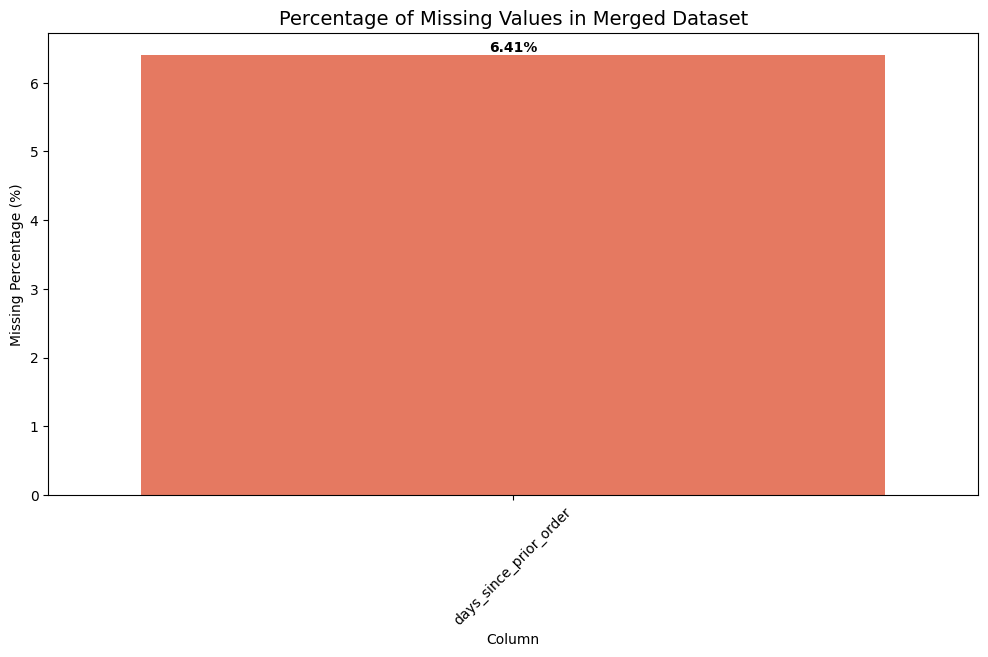

Missing values details:
                   Column  Missing_Count  Missing_Percentage
9  days_since_prior_order        2078068             6.40697


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. حساب القيم المفقودة في الملف المدمج النهائي (instacart_data)
# هذا الملف يحتوي على البيانات من جميع الجداول المدمجة
missing_count = instacart_data.isnull().sum()
missing_pct = (missing_count / len(instacart_data)) * 100

# 2. إنشاء DataFrame للنتائج لعرضها
missing_df = pd.DataFrame({
    'Column': missing_count.index,
    'Missing_Count': missing_count.values,
    'Missing_Percentage': missing_pct.values
})

# تصفية الأعمدة التي تحتوي على قيم مفقودة فقط
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values(by='Missing_Percentage', ascending=False)

if not missing_df.empty:
    # 3. رسم بياني يوضح النسب المئوية للقيم المفقودة (Bar Chart)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Column', y='Missing_Percentage', data=missing_df, palette='Reds_r')

    # إضافة الأرقام فوق الأعمدة
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f') + '%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9), textcoords = 'offset points',
                    fontsize=10, fontweight='bold')

    plt.title('Percentage of Missing Values in Merged Dataset', fontsize=14)
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    plt.show()

    print("Missing values details:")
    print(missing_df)
else:
    print("No missing values found in the merged dataset!")